In [1]:
# Library imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize
import sympy as sp
from matplotlib import cm

In [2]:
# Source under probe
FreqHz = 1e6 # Fundamental frequency of simulation
Tperiod = 1 / FreqHz # Fundamental time period of simulation
Nsamp = int(1e6) # Number of samples
t = np.arange(Nsamp, dtype=float) * Tperiod # Time series: (0...Nsamp) * Time period

Tr = Tperiod * 100000 # Time period of motion we are trying to measure: 100 x sampling time period
Omega = 2 * np.pi / Tr # Omega of motion
xr = 100 * np.sin(Omega * t) # X position of motion, let's say it's a sinusoid with amplitude 100 (degrees)

/Users/charmipatel/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


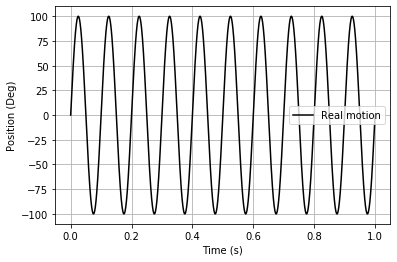

In [3]:
# Let's see what the motion looks like
plt.figure()
plt.plot(t, xr, c = 'k', label = 'Real motion')
plt.xlabel('Time (s)')
plt.ylabel('Position (Deg)')
plt.grid()
plt.legend()
plt.show()

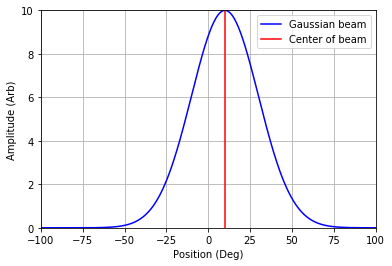

In [4]:
# This is for 1D Beam
gridMax = 100
xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing

# Define 1D Gaussian, which is our beam
def gauss1D(xx, mx, s):
    xx_ = xx - mx
    return np.exp(-0.5 * xx_ * xx_ / (s * s))

# Test Gaussian
plt.plot(xx, 10 * gauss1D(xx, 10, 20), color = 'b', label = 'Gaussian beam')
plt.xlabel('Position (Deg)')
plt.ylabel('Amplitude (Arb)')
plt.ylim(0, 10)
plt.xlim(-gridMax, gridMax)
plt.axvline(10, c = 'r', label = 'Center of beam')
plt.legend()
plt.grid()
plt.show()

In [5]:
# # Animation of the beam
# from IPython.display import HTML
# from matplotlib import animation

# fig = plt.figure(figsize = (10, 6))
# ax = plt.axes(xlim=(-gridMax, gridMax), ylim=(0, 10))
# fig.suptitle('Time: %d milliseconds' % (0))
# plt.grid()
# line, = ax.plot([], [], lw=2, c = 'b', label = 'Beam')
# fskip = 800 # one frame per 16 milisecond

# def init():
#     line.set_data([], [])
#     plt.legend()
#     return line, # return a tuple

# def animate(fid):
#     tid = (fid * fskip) % xr.shape[0] # Time ID: frame ID * frame skip, the modulo keeps it from exceeding array size
#     fig.suptitle('Time: %d milliseconds' % (1e3 * t[tid]))
#     y = 10 * gauss1D(xx, xr[tid], 15) # beam at tid, which is index of time (time = tid * Tperiod)
#     line.set_data(xx, y) # plot X and Y
# #     ax.axvline(xr[tid], c = 'r', label = 'Center of beam')
#     return line,

# anim = animation.FuncAnimation(fig, animate, init_func = init, frames = xr.shape[0] // fskip, interval = 17, blit = True)
# HTML(anim.to_html5_video()) # requires ffmpeg, install using `conda install ffmpeg`
    

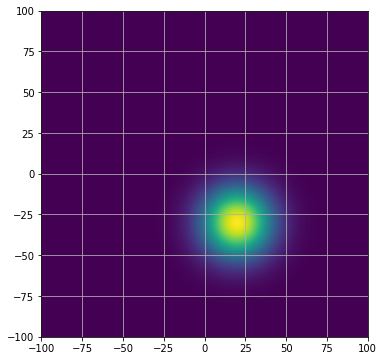

In [6]:
# This is for 2D Beam

# Now we generate our beam, which is a Gaussian in 2D space around the X coordinate
gridMax = 100
xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing
yy = xx # square grid so make an alias
(xp, yp) = np.meshgrid(xx, yy) # generate X-Y plane

# Define 2D Gaussian:
def gauss2D(xx, yy, mx, my, s):
    xx_ = xx - mx # Recenter X
    yy_ = yy - my # Recenter Y
    dist = (xx_*xx_ + yy_*yy_) # calculate Euclidean distance on 2D plane
    return np.exp(-0.5 * dist / (s * s)) # Gaussian: exp(-x^2/2s^2)

# Test Gaussian
plt.figure(figsize=(6,6))
gaussval = gauss2D(xp, yp, 20, 30, 15) # beam at (20, 30), width 15
plt.imshow(gaussval, extent = [-gridMax, gridMax, -gridMax, gridMax])
plt.grid()
plt.show()

# plt.figure(figsize=(6,6))
# ax = fig.gca(projection='3d')
# ax.plot_surface(xp, yp, gaussval, cmap=cm.coolwarm)
    

# now to generate the REAL beam position with time, we need to
# generate a 3D array of the position of these 


In [7]:
sigr = np.array([gauss2D(xp, yp, mx, 0, 10) for mx in xr[:10000]]) # beam from source, width 10

## Steepest Descent
Note that, the actual beam is spread in space at every moment in time.
However, at any moment in time we can only sample one point in space (or average of a small area in space).
A-priori information is the peak of the beam at $t = 0$.
At subsequent points in time, as the peak of the beam moves about, we need to find it. 

#### At any point of time, you can ONLY sample one point in space or the average of a small area in space.

(501,)


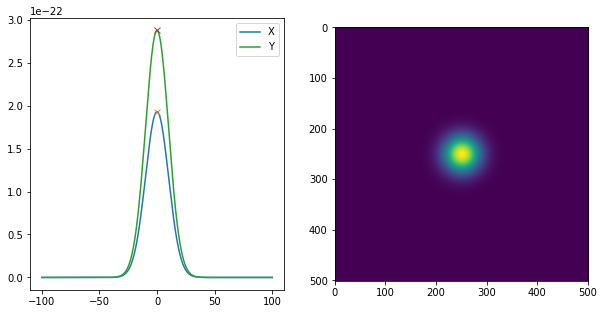

In [95]:
print(np.shape(sigr[1][0]))

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,5))
ax1.plot(xx,sigr[1][0], label = "X")
ax1.plot(xx[np.argmax(x_)],max(x_), 'x-' )
ax1.plot(yy,sigr[1][1], label ='Y')
ax1.plot(yy[np.argmax(y_)],max(y_), 'x-' )
ax1.legend()

ax2.imshow(sigr[1])

(10000, 501, 501)
(501,)
(501, 501)


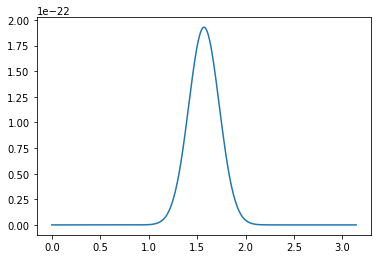

In [159]:
# print(np.shape(sigr))
# print(np.shape(sigr[0][0]))
# print(np.shape(sigr[:10][0]))
# # plt.contour(sigr[0][0],sigr[0][1] )
# # plt.contour(sigr[0])
# # plt.pcolormesh(sigr[0])

# plt.plot(xr[:501], sigr[:1000][0][0])

In [8]:
# def df(func , d ,h=0.01):
#     xx = d[0] ; yy = d[1]
#     dx = (func([(xx + h),yy]) - func([(xx - h),yy]))/(2*h)
#     dy = (func([xx, (yy + h)]) - func([xx, (yy - h)]))/(2*h)
#     return [dx,dy]


(10000,)

In [121]:
# import numpy as np
# import random


# def gradient_descent(alpha, x, precision=0.0001, max_iter=1000):
#     converged = False
#     iter = 0
#     m = x.shape[0] # number of samples

#     #initial theta
# #     t0 = np.random.random(x.shape[0])
# #     t1 = np.random.random(x.shape[0])
#     t0 = xx
#     t1 = yy

#     # total error, J(theta)
#     J = np.sum([(t0 + t1*x[i])**2 for i in range(m)])

#     # Iterate Loop
#     while not converged:
#         # for each training sample, compute the gradient (d/d_theta j(theta))
#         grad0 = 1.0/m * sum([(t0 - t1*x[i] ) for i in range(m)]) 
#         grad1 = 1.0/m * sum([(t0 - t1*x[i] )*x[i] for i in range(m)])
# #         grad0 = 1.0/m * sum([(t0 + t1*x[i] - y[i]) for i in range(m)]) 
# #         grad1 = 1.0/m * sum([(t0 + t1*x[i] - y[i])*x[i] for i in range(m)])

#         # update the theta_temp
#         temp0 = t0 - alpha * grad0
#         temp1 = t1 - alpha * grad1
    
#         # update theta
#         t0 = temp0
#         t1 = temp1

#         # mean squared error
#         e = np.sum( [ (t0 + t1*x[i])**2 for i in range(m)] ) 


#         if abs(J-e) <= precision:
#             print('Converged, iterations: ', iter, '!!!')
#             converged = True
    
#         J = e   # update error 
#         iter += 1  # update iter
    
#         if iter == max_iter:
#             print ('Max interactions exceeded!')
#             converged = True

#     return t0,t1
########################################################

# alpha = 0.1
# x_ = sigr[1][0]
# y_ = sigr[1][1]
# works0, works1 = gradient_descent(alpha, x_)
# print(works0[-1], works1[-1])

########################################################

# print(max(x_))
# print(np.argmax(x_))
# result0 = np.where(x_ == works0[-1])
# result1 = np.where(y_ == works1[-1])

#######################################################

# fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,5))
# ax1.plot(xx,sigr[1][0], label = "X")
# ax1.plot(xx[result0], works0[-1])
# ax1.plot(yy,sigr[1][1], label ='Y')
# ax1.plot(yy[result1], works1[-1])
# ax1.legend()

# ax2.imshow(sigr[1])

In [190]:
def df_forward(x,y):
    dydx = np.zeros(len(x))
    for i in range(len(x)-1):
        dydx[i] = (y[i+1] - y[i])/ (x[i+1] - x[i])
        
    return dydx

In [191]:
df = df_forward(xx,x_)
df

array([ 4.53473339e-44,  6.72695525e-44,  9.96284805e-44,  1.47314877e-43,
        2.17474219e-43,  3.20528736e-43,  4.71654646e-43,  6.92913720e-43,
        1.01632367e-42,  1.48827332e-42,  2.17586059e-42,  3.17597507e-42,
        4.62829135e-42,  6.73382489e-42,  9.78138613e-42,  1.41852299e-41,
        2.05385453e-41,  2.96893191e-41,  4.28477461e-41,  6.17380410e-41,
        8.88126350e-41,  1.27553871e-40,  1.82898201e-40,  2.61831597e-40,
        3.74223825e-40,  5.33995372e-40,  7.60746842e-40,  1.08203012e-39,
        1.53650859e-39,  2.17834671e-39,  3.08329662e-39,  4.35712297e-39,
        6.14724401e-39,  8.65878847e-39,  1.21767044e-38,  1.70961480e-38,
        2.39641791e-38,  3.35368708e-38,  4.68573933e-38,  6.53625858e-38,
        9.10281563e-38,  1.26566158e-37,  1.75693088e-37,  2.43493231e-37,
        3.36910191e-37,  4.65410675e-37,  6.41879301e-37,  8.83822670e-37,
        1.21498673e-36,  1.66752540e-36,  2.28490317e-36,  3.12577314e-36,
        4.26914897e-36,  

In [195]:
# guesses = [[-42,30]]


def gradient_descent_3(indep, dep, alpha, max_iter, precision ):
    
    xx0 = indep[0]  # guess x
    x_0 = dep[0] # guess y
    guesses = [xx0]
    df = df_forward(indep,dep)
    while True:
        print(guesses)
        for i in range(len(indep)):
            x_temp = x_0 - alpha * df_forward(i)
    #         y_temp = y0 - alpha * df_forward( yy, y_ )

    #         guesses.append([x_temp,y_temp])
            guesses.append([x_temp])


            count += 1
            print(count)
            if count > max_inter:
                print ("too many iternations, adjust alpha")
                break

    #         if abs(x_temp - guesses[0][0]) < precision and abs(y_temp - guesses[0][1]) < precision:
            if abs(x_temp - guesses[0]) < precision:
                break


            x0 = x_temp
    #         y0 = y_temp

    return guesses

In [196]:
print(len(x_))

501


In [197]:
precision = 1/1000000
max_iter = 100
alpha = 0.1
count = 0

works = gradient_descent_3(xx,x_,alpha, max_iter, precision)

[-100.0]


TypeError: df_forward() missing 1 required positional argument: 'y'

In [ ]:
fig = plt.figure(figsize= (10,8))
plt.contour(x_mesh, y_mesh, f_mesh, 50)
it_array = np.array(guesses)
plt.plot(it_array.T[0], it_array.T[1], "x-")
ax.set_xlabel('x')
ax.set_ylabel('y')

print("the minima is at :", guesses[-1])



In [123]:
print(max(x_))
print(np.argmax(x_))

1.9287494672439914e-22
250


In [124]:
result0 = np.where(x_ == works0[-1])
result1 = np.where(y_ == works1[-1])

In [125]:
print(result0)

(array([], dtype=int64),)


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

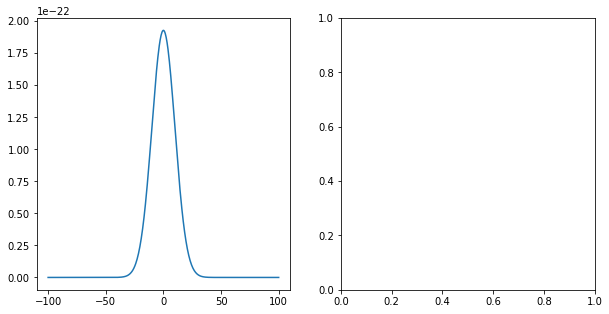

In [64]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,5))
ax1.plot(xx,sigr[1][0], label = "X")
ax1.plot(xx[result0], works0[-1])
ax1.plot(yy,sigr[1][1], label ='Y')
ax1.plot(yy[result1], works1[-1])
ax1.legend()

ax2.imshow(sigr[1])

In [9]:
guesses = [[-42,30]]
precision = 1/1000000
max_interations = 100
alpha = 0.1
count = 0

x0 = guesses[0][0]  # guess x
y0 = guesses[0][1] # guess y
while True:
    print(guesses)
    
#     x_temp = x0 - alpha * df( f , [x0,y0] )[0]
#     y_temp = y0 - alpha * df( f , [x0,y0] )[1]
    for i in range(epochs):
          y_pred = w * x +c
           = (-2/n) * sum(x * (y_original - y_pred))
          D_C = (-2/n) * sum(y_original - y_pred)
    
    guesses.append([x_temp,y_temp])
    
    count += 1
#     print(count)
    if count > max_interations:
        print ("too many iternations, adjust alpha")
        break
    
    if abs(x_temp - guesses[0][0]) < precision and abs(y_temp - guesses[0][1]) < precision:
        break
    
    
    x0 = x_temp
    y0 = y_temp

fig = plt.figure(figsize= (10,8))
plt.contour(x_mesh, y_mesh, f_mesh, 50)
it_array = np.array(guesses)
plt.plot(it_array.T[0], it_array.T[1], "x-")
ax.set_xlabel('x')
ax.set_ylabel('y')

print("the minima is at :", guesses[-1])

[[-42, 30]]


NameError: name 'f' is not defined